Same contents as [visual_task-working_with_two_sessions.ipynb] but experimenting a little bit with *hyperopt* to do model selection.

In [1]:
%matplotlib inline
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from matplotlib.ticker import StrMethodFormatter

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import (classification_report, 
                             confusion_matrix, 
                             accuracy_score,
                             f1_score)
from sklearn.model_selection import (cross_val_predict, 
                                     cross_val_score, 
                                     GridSearchCV, 
                                     StratifiedKFold, 
                                     StratifiedShuffleSplit,
                                     train_test_split)
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve, learning_curve

In [3]:
from hyperopt import hp, fmin, rand, tpe, Trials, STATUS_FAIL, STATUS_OK, space_eval
from hyperopt.pyll import scope

In [4]:
scope.define(SVC)
scope.define(LinearSVC)
scope.define(LogisticRegression)
scope.define(RandomForestClassifier)

sklearn.ensemble.forest.RandomForestClassifier

In [5]:
def plot_bin_scores(scores, ax):
    gb = scores.groupby(by="bin", as_index=False)
    scores_mean = gb.mean()["acc"]
    scores_std = gb.std()["acc"]
    num_bins = len(scores_mean)
    x = np.arange(num_bins)
    ax.plot(x, scores_mean)
    ax.fill_between(x, scores_mean - scores_std, 
                    scores_mean + scores_std, alpha=0.15)
    ax.set_xlabel('Bin number')
    ax.set_ylabel('Accuracy')
    ax.grid()
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0%}'))
    return ax, scores_mean

In [6]:
!ls data/visual

old_s1	p22_bins20ms  p24_20ms	   p27	     p27_movcorr
p22	p24	      p24_movcorr  p27_20ms


In [7]:
n_jobs = 10

# Concatenate sessions

In [8]:
participant = 'p24_movcorr'
n_trials = 79 * 2 # because we concatenate two sessions

In [9]:
ve0_file = sorted(glob('data/visual/{}*/VE0*'.format(participant)))
ve1_file = sorted(glob('data/visual/{}*/VE1*'.format(participant)))

In [10]:
def read_ve(ve_file):
    ve = pd.read_csv(ve_file, header=None).transpose()
    new_header = ve.iloc[0]
    ve = ve[1:]
    ve.columns = new_header
    # 'EOG002', 'EOG003', 
    ve = ve.drop(['EOG002', 'EOG003', 'STI016', 'STI101', 'STI102', 'SYS101', 'SYS201', 
                    'CHPI001', 'CHPI002', 'CHPI003', 'CHPI004', 'CHPI005',
                    'CHPI006', 'CHPI007', 'CHPI008', 'CHPI009'],
                    axis=1)
    ve = ve.apply(pd.to_numeric, errors='ignore')    
    return ve

In [11]:
ve0 = pd.concat([read_ve(ve) for ve in ve0_file],
                ignore_index=True)

ve1 = pd.concat([read_ve(ve) for ve in ve1_file],
                ignore_index=True)

In [12]:
bins_per_trial = int(ve0.shape[0] / n_trials)
print(bins_per_trial)

100


A simple visual confirmation that we have two different time series for VE0 and VE1.

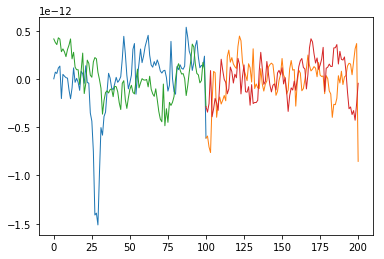

In [13]:
plt.plot(ve0.loc[:bins_per_trial, 'MEG0111'], lw=1)
plt.plot(ve0.loc[bins_per_trial:bins_per_trial*2, 'MEG0111'], lw=1)
plt.plot(ve1.loc[:bins_per_trial, 'MEG0111'], lw=1)
plt.plot(ve1.loc[bins_per_trial:bins_per_trial*2, 'MEG0111'], lw=1)

In [14]:
timebin_to_take = 5

In [73]:
# ve0.columns.get_loc("MEG1521")
X_0 = ve0.iloc[:, :].values
X_1 = ve1.iloc[:, :].values

In [74]:
X_0 = X_0.reshape(n_trials, bins_per_trial, -1)
X_1 = X_1.reshape(n_trials, bins_per_trial, -1)
# [trial_number, bin, sensor]
print(X_0.shape)
print(X_1.shape)

(158, 100, 306)
(158, 100, 306)


In [124]:
X = np.vstack((X_0[:, timebin_to_take, :], 
               X_1[:, timebin_to_take, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

In [125]:
pipeline = make_pipeline(MaxAbsScaler(),
                         # PCA(n_components=.99, svd_solver='full'),
                         LogisticRegression(C=1, 
                                            solver='liblinear', 
                                            penalty='l1')
                         )
cvss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
cvsk = StratifiedKFold(n_splits=20, random_state=42)

In [126]:
y_pred = cross_val_predict(pipeline, X, y, cv=cvsk, n_jobs=n_jobs)

In [127]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

         -1       0.52      0.51      0.52       158
          1       0.52      0.53      0.52       158

avg / total       0.52      0.52      0.52       316



In [128]:
print(confusion_matrix(y, y_pred))

[[81 77]
 [75 83]]


In [129]:
lrl1_hyperopt_search_space = {}
lrl1_hyperopt_search_space['logisticregression__C'] = hp.loguniform('lrl1_C', -2, 2)

def lrl1_hyperopt_objective(params):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cvsk)
    return -1 * scores.mean()

We want to identify what is the bin accuracy and which bin is the best.

In [131]:
bin_scores = {}
best_params = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X = np.vstack((X_0[:, b, :], 
                   X_1[:, b, :]))
    y = np.repeat([-1, 1], int(X.shape[0] / 2))
    this_bin_scores = []
    # this_bin_scores = cross_val_score(pipeline, X, y, cv=cvsk, n_jobs=n_jobs)
    for tr, te in cvsk.split(X, y):
        X_train = X[tr]
        X_test = X[te]
        y_train = y[tr]
        y_test = y[te]
        find_best_pipeline = fmin(lrl1_hyperopt_objective,
                                  lrl1_hyperopt_search_space,
                                  algo=tpe.suggest,
                                  max_evals=10)        
        this_bin_params = space_eval(lrl1_hyperopt_search_space, find_best_pipeline)
        best_model = pipeline.set_params(**this_bin_params)
        best_model.fit(X_train, y_train)
        score = best_model.score(X_test, y_test)
        this_bin_scores.append(score)
    best_params[b] = this_bin_params
    bin_scores[b] = this_bin_scores
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [132]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [133]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [134]:
sorted_scores

bin       acc
36   36  0.756696
33   33  0.746429
37   37  0.741518
32   32  0.735268
30   30  0.727232
34   34  0.692411
35   35  0.683036
41   41  0.654018
50   50  0.651339
31   31  0.648214

In [135]:
best_bin = sorted_scores.bin.iloc[0]

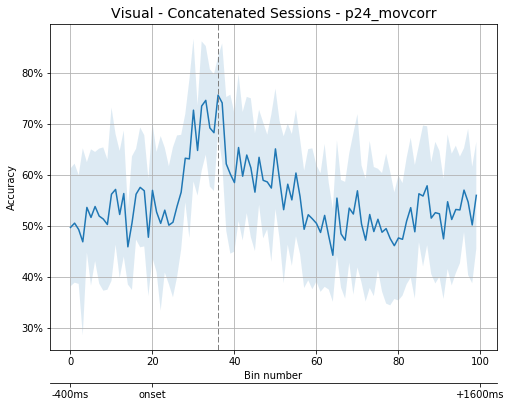

In [136]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Visual - Concatenated Sessions - {}'.format(participant),
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.1))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

# Optimize best bin with hyperopt

In [109]:
X = np.vstack((X_0[:, best_bin, :], 
               X_1[:, best_bin, :]))
y = np.repeat([-1, 1], int(X.shape[0] / 2))

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [111]:
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [112]:
C = hp.loguniform('c', -3, 3)
choices_list = [
    (scope.SVC(kernel='linear', C=C)),
    (scope.SVC(kernel='rbf', C=C, gamma=hp.loguniform('gamma', -4, 1))),
    (scope.LinearSVC(C=C, penalty='l1', dual=False)),
    (scope.LogisticRegression(C=C, penalty='l1'))
]
search_space = hp.choice('estimator', choices_list)

In [113]:
# Create logger using the Trials object supplied by hyperopt
trials = Trials()

In [114]:
def objective_function(estimator):
    # estimator.fit(X_train, y_train)
    
    # y_hat = estimator.predict(X_test)
    scores = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cvsk)
    # return -1 * f1_score(y_test, y_hat)
    return -1 * scores.mean()

In [115]:
# Call fmin
best = fmin(
    fn=objective_function,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100
)
print(best)

{'c': 1.060378957117325, 'gamma': 0.035080283679113734, 'estimator': 1}


In [116]:
space_eval(search_space, best)

SVC(C=1.060378957117325, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.035080283679113734,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [117]:
# clf = LinearSVC(C=2.9773899456340547)
# clf = RandomForestClassifier(max_depth=1, min_samples_split=0.8714861887808678)
clf = space_eval(search_space, best)

In [118]:
clf.fit(X_train, y_train)

SVC(C=1.060378957117325, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.035080283679113734,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [119]:
y_pred = clf.predict(X_test)

In [120]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

         -1       0.79      1.00      0.88        15
          1       1.00      0.76      0.87        17

avg / total       0.90      0.88      0.87        32



In [121]:
accuracy_score(y_test, y_pred)

0.875

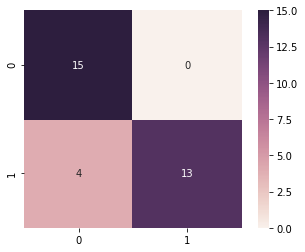

In [123]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, square=True)

# Learning curve and validation curve for the concatenated datasets using the best bin.

In [42]:
# possible_cs = np.logspace(-2, 3, 6)
possible_cs = [1e-3, 1e-2, 1e-1, 1, 5, 10, 50, 1e2, 5e2, 1e3]
possible_cs = np.asarray(possible_cs)
train_scores, valid_scores = validation_curve(pipeline, X, y, 
                                              "logisticregression__C",
                                              possible_cs,
                                              cv=cvss,
                                              n_jobs=n_jobs)

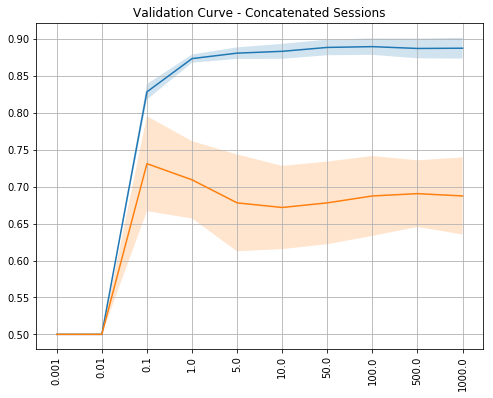

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
mean_train = train_scores.mean(axis=1)
mean_valid = valid_scores.mean(axis=1)
std_train = train_scores.std(axis=1)
std_valid = valid_scores.std(axis=1)
ax.plot(mean_train)
ax.plot(mean_valid)
x = np.arange(mean_train.size)
ax.fill_between(x, mean_train + std_train, mean_train - std_train, alpha=0.2)
ax.fill_between(x, mean_valid + std_valid, mean_valid - std_valid, alpha=0.2)
ax.set_xticks(range(possible_cs.size))
_ = ax.set_xticklabels(possible_cs, rotation=90)
ax.set_title('Validation Curve - Concatenated Sessions')
ax.grid()

In [44]:
train_sizes, train_scores, valid_scores = learning_curve(
    pipeline, 
    X, y, 
    train_sizes=np.linspace(.1, 1., num=10), 
    cv=cvss,
    n_jobs=n_jobs
)

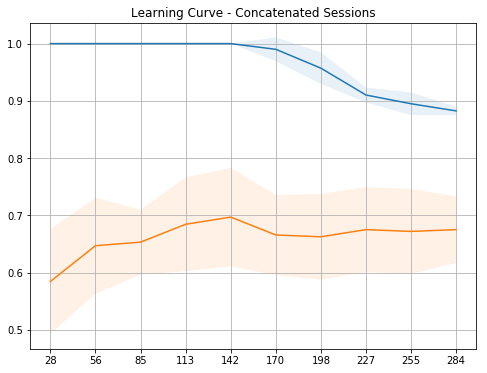

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
valid_mean = valid_scores.mean(axis=1)
valid_std = valid_scores.std(axis=1)
x = range(train_sizes.size)
ax.plot(x, train_mean)
ax.fill_between(x, train_mean + train_std, train_mean - train_std, alpha=0.1)
ax.plot(x, valid_scores.mean(axis=1))
ax.fill_between(x, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1)
ax.set_xticks(x)
_ = ax.set_xticklabels(train_sizes)
ax.set_title('Learning Curve - Concatenated Sessions')
ax.grid()

# Train on one session, test on the other

In [46]:
X_0.shape

(158, 100, 306)

In [47]:
X_0_1 = X_0[int(n_trials / 2):] # first session
X_0_2 = X_0[:int(n_trials / 2)] # second session
X_1_1 = X_1[int(n_trials / 2):]
X_1_2 = X_1[:int(n_trials / 2)]

In [48]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_f = np.concatenate((X_0_1[:, b, :], X_1_1[:, b, :]))
    y_f = np.repeat([-1, 1], int(X_f.shape[0] / 2))
    X_s = np.concatenate((X_0_2[:, b, :], X_1_2[:, b, :]))
    y_s = np.repeat([-1, 1], int(X_s.shape[0] / 2))
    pipeline_fit = pipeline.fit(X_f, y_f)
    y_pred = pipeline_fit.predict(X_s)
    this_bin_scores = accuracy_score(y_s, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [49]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [50]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [51]:
sorted_scores

bin       acc
32   32  0.708861
36   36  0.664557
33   33  0.664557
37   37  0.658228
35   35  0.645570
45   45  0.626582
29   29  0.613924
30   30  0.613924
34   34  0.607595
43   43  0.601266

In [52]:
best_bin = sorted_scores.bin.iloc[0]

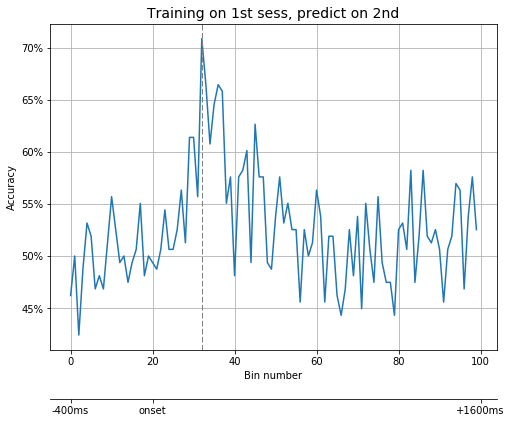

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Training on 1st sess, predict on 2nd',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)

Now, second on first.

In [54]:
bin_scores = {}
# bins_per_trial = 0
for b in range(bins_per_trial):
    X_f = np.concatenate((X_0_1[:, b, :], X_1_1[:, b, :]))
    y_f = np.repeat([-1, 1], int(X_f.shape[0] / 2))
    X_s = np.concatenate((X_0_2[:, b, :], X_1_2[:, b, :]))
    y_s = np.repeat([-1, 1], int(X_s.shape[0] / 2))
    pipeline_fit = pipeline.fit(X_s, y_s)
    y_pred = pipeline_fit.predict(X_f)
    this_bin_scores = accuracy_score(y_f, y_pred)
#     this_bin_scores = cross_val_score(gscv, X, y, cv=10)
    bin_scores[b] = [this_bin_scores]
#     print('bin {}: {:.3%} ACC'.format(
#           b, np.mean(this_bin_scores)))

In [55]:
scores = pd.melt(pd.DataFrame(bin_scores), var_name="bin", value_name="acc")

In [56]:
sorted_scores = (scores
                 .groupby(by="bin", as_index=False)
                 .mean()
                 .sort_values(by='acc', ascending=False)
                 .head(10)
                )

In [57]:
sorted_scores

bin       acc
32   32  0.696203
36   36  0.658228
30   30  0.658228
33   33  0.651899
35   35  0.632911
29   29  0.632911
40   40  0.632911
34   34  0.632911
37   37  0.620253
46   46  0.613924

In [58]:
best_bin = sorted_scores.bin.iloc[0]

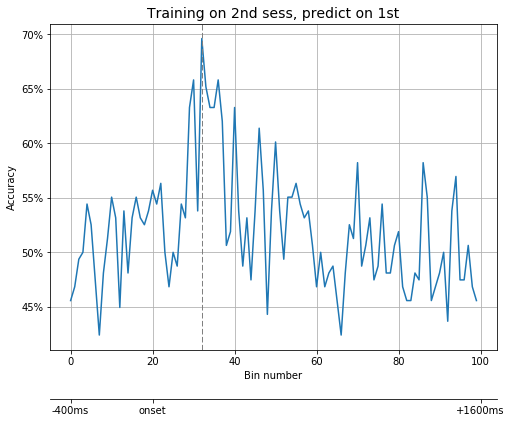

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))
ax, score_means = plot_bin_scores(scores, ax)
ax.set_title('Training on 2nd sess, predict on 1st',
             fontsize=14)
ax2 = ax.twiny()
ax2.plot(range(len(score_means)), score_means, alpha=0)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
for sp in ax2.spines.values():
    sp.set_visible(False)
ax2.spines["bottom"].set_visible(True)
ax2.set_xticks([0, 20, 100])
ax2.set_xticklabels(["-400ms", "onset", "+1600ms"])
ax.axvline(best_bin, color='grey', ls='--', lw=1)